In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist

rc={'lines.linewidth': 2, 'axes.labelsize': 20, 'axes.titlesize': 14, 'lines.markersize':15,
    'legend.fontsize':20, 'xtick.labelsize':15, 'ytick.labelsize':15}
sns.set(rc=rc)
sns.set_style('white')

# Auxiliary tutorial 6: K-means clustering

## What is clustering?

Dividing data into clusters, or groups, can be helpful in exploratory data analysis. The goal of clustering is to form groups containing data objects that are similar within groups and different between groups. Because the clusters are derived from the data itself, i.e. there is no training with labeled data, cluster analysis is often refered to as an unsupervised learning method.

This procedure can provide meaningful insights into the structure of a dataset, or it can be useful for summarizing the data for further analysis. However, it is good to keep in mind that the definition of a cluster is imprecise:

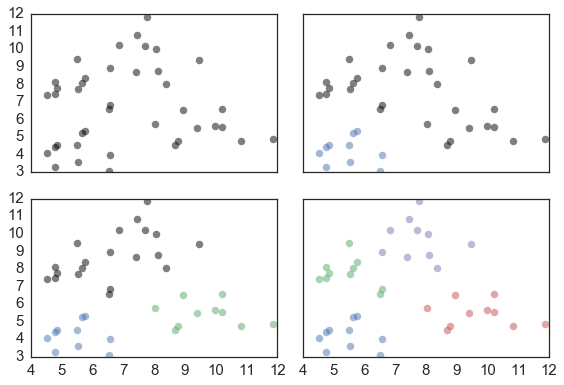

In [2]:
# generate data 
np.random.seed(42) 
means = (5, 5, 8, 10) 
coords = [np.random.normal(mean, 1, 10) for mean in means]

# plot 
fig, axes = plt.subplots(2,2, sharey=True, sharex=True)
# no clusters
axes[0,0].plot(coords[0], coords[1], 'k.', coords[0], coords[2], 'k.',
    coords[3], coords[0], 'k.', coords[2], coords[3], 'k.', alpha = 0.5)
# two clusters
axes[0,1].plot(coords[0], coords[1], '.', coords[0], coords[2], 'k.',
    coords[3], coords[0], 'k.', coords[2], coords[3], 'k.', alpha = 0.5)
# three clusters
axes[1,0].plot(coords[0], coords[1], '.', coords[0], coords[2], 'k.',
    coords[3], coords[0], '.', coords[2], coords[3], 'k.', alpha = 0.5)
# four clusters
axes[1,1].plot(coords[0], coords[1], '.', coords[0], coords[2], '.',
    coords[3], coords[0], '.', coords[2], coords[3], '.', alpha = 0.5)
plt.tight_layout();

These are all different ways of clustering the same set of points. There is no universally correct way of clustering; the most appropiate definition will depend on the data and the desired output, and is often found through experimentation. For these reasons, there are several clustering algorithms. Also for these reasons, we should be careful about the conclusions we draw from clustering analysis, as they can vary widely depending on the algorithm and the parameters that we choose.

Two major clustering categories refer to whether the data is being grouped hierarchically or partitionally. In the former, each cluster belongs to a larger cluster that contains multiple clusters and so on, until the whole dataset is the cluster that contains all, in a dendogram fashion. In the latter, the clusters are non-overlapping and each data object belongs to only one cluster. To get a taste of clustering, we will take look at a partitional algorithm, K-means, which is one of the first and fastest clustering algorithms.

## The K-means clustering algorithm



K-means is a centroid-based clustering algorithm. This means that a cluster is defined as a set of objects in which each object is *closer* to the center of its own cluster than to the center of other clusters. It thus needs a distance metric to quantify how close data are to any given point. Euclidean distance, which is simply the length of the line segment connecting two points, is one such metric that is often used. In $n$ dimensions, the squared euclidean distance between points $p$ and $q$ is:
$$ \sum_{i=1}^{n} (p_i - q_i)^2 $$

The basic algorithm for K-Means clustering, also known as Lloyd's algorithm, is as follows:
1. Select an initial set of $k$ centroids.

Repeat these two steps until convergence:
2. Assign each point to the closest centroid.
3. Change the centroids to be the means of the newly formed clusters.

Convergence is reached when the centroids and assignments no longer change. Given that each point is iteratively assigned to the closest centroid, these steps minimize the so called *inertia*, or within-cluster sum of squared criterion::
$$ \text{inertia} = \sum_{i=1}^{k}\sum_{x\in C_i} d(c_i, x)^2 $$

Where $k$ is the number of centroids, $C_i$ is the $i^{th}$ cluster with mean $c_i$, $x$ is a point in that cluster, and $d$ is the euclidean distance between these two points. The mean of the points in the cluster, $c_i$, is the best centroid for minimizing the inertia. This can be shown by solving for the $c_k$ centroid, which is done by finding when it stops changing, i.e. differentiating and setting equal to zero. In the simplest, one dimensional case:

$$ \frac{\partial}{\partial c_k} \sum_{i=1}^{k}\sum_{x\in C_i} (c_i - x)^2 $$
$$ = \sum_{x\in C_k} 2 * (c_k - x_k) = 0 $$
$$ = \sum_{x\in C_k} (c_k - x_k) = 0 $$
$$ \sum_{x\in C_k} c_k = \sum_{x\in C_k} x_k $$
$$ m_kc_k = \sum_{x\in C_k} x_k$$
$$ c_k = \frac{1}{m_k} \sum_{x\in C_k} x_k$$

Where $m_k$ is the size of the $k^{th}$ cluster. 

With this information, we can code up a simple version of the algorithm to cluster one dimensional data with random centroid initialization.  We will start by writing functions to do each of the three steps of the algorithm: centroid initialization, assignment and re-computation. We will also need one to compute the euclidean distance.

In [32]:
def select_centroids(data, k):
    """ 
    Randomly select initial k number of centroids
    """
    return np.random.choice(int(np.ceil(max(data))), size=k, replace=False)

def compute_distance(centroids, x):
    """
    Compute squared euclidean distance between two points
    """
    return [(c - x)**2 for c in centroids]

def assign_centroids(centroids, data):
    """
    Assign data to closest centroid and cluster
    """
    # compute distances
    centroid_distances = compute_distance(centroids, data)
    # get closest centroid
    ind = np.array([np.argmin(c) for c in zip(*centroid_distances)])
    closest_centroid = centroids[ind]
    # assign data and cluster 
    clusters = [data[np.where(closest_centroid==c)] for c in centroids]
    return np.array(clusters)

def compute_centroids(clusters):
    """
    Compute new centroids for clusters
    """
    new_centroids = np.array([np.mean(c) for c in clusters])
    # check for empty clusters, replace with 0
    if np.isnan(new_centroids).any():
        new_centroids = np.nan_to_num(new_centroids)
    return new_centroids

We will now write a function to plot a sample of the iterations so that we can see what the algorithm is doing.

In [ ]:
def plot_clustering(clusters, centroids, n_plots, title='iteration'):
    """
    Plot clustering iterations
    """
    to_plot = np.linspace(0, len(centroids)-1, num=n_plots, dtype=int)
    fig, axes = plt.subplots(n_plots, sharex=True, sharey=True)
    for i, ax in enumerate(axes):
        # centroids
        curr_cs = centroids[to_plot[i]]
        #ax.plot(curr_cs, np.full_like(curr_cs, 1), 'r.', markersize=30, alpha=0.2)
        ax.vlines(curr_cs, 0, 2, 'r', alpha=0.5)
        # clustered data
        curr_cls = clusters[to_plot[i]]
        for cluster in curr_cls:
            ax.plot(cluster, np.full_like(cluster,1), '.', alpha=0.2)
        ax.set_title("{0} {1}".format(title, to_plot[i]+1))
    # remove meaningless y ticks and tighten plot
    plt.yticks([])
    plt.tight_layout()
    return

We have everything we need. Now we can construct our procedure by simply plugging in each step and iterating until convergence.

In [31]:
def Kmeans_1D(data, k=2, plot_iter=0, verbose=False):
    """
    Perform K-Means clustering on 1D data
    """
    # get initial centroids and make an array to save each set of centroids
    centroids = select_centroids(data, k)
    curr_centroids = np.zeros_like(centroids)
    
    # count iterations and save initial centroids
    n, c = 0, centroids
    
    # to save iterations if plotting requested
    past_clusters, past_centroids = [], []
    
    # check for convergence (if centroids don't change)
    while not np.isclose(np.sum(curr_centroids - centroids), 0):
        
        # update centroids
        curr_centroids = centroids
        # assign each point to closest centroid
        clusters = assign_centroids(centroids, data)
        # recompute centroids
        centroids = compute_centroids(clusters)
        # update counter
        n+=1
        
        # save all iterations for plot if requested
        if plot_iter > 0:
            past_clusters.append(clusters)
            past_centroids.append(centroids)
    
    if plot_iter > 0:
        plot_clustering(past_clusters, past_centroids, plot_iter)
    
    if verbose:
        print("K = {0}\nInitial centroids were: {1}\nFinal centroids were:{2}\
              \nConverged after {3} iterations".format(k, c, centroids, n))
    
    return centroids, clusters

We should now have our clustering algorithm ready. Let's write a function to generate 1D data by getting samples from multiple normal distributions, so we can try it out. 

In [4]:
def generate_data(n, var, means):
    """
    Generate 1D data to cluster from multiple normal distributions
    """
    for m in means:
        dist = np.random.normal(m, var, size=int(n/len(means)))
        try:
            data = np.concatenate([data, dist])
        except NameError: 
            data = dist
    np.random.shuffle(data)
    return data

We will make our toy data to have 100 samples from 4 normal distributions with unit variance and means uniformly distributed between 0 and 20.

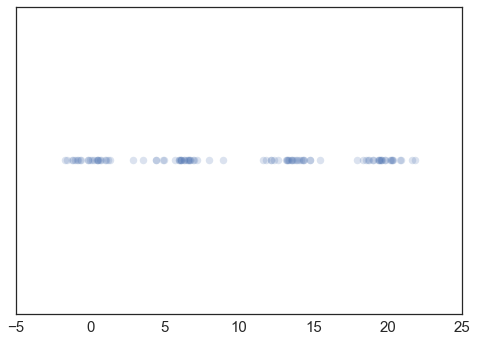

In [5]:
np.random.seed(12)
# 1D data to cluster from k normal distributions
n_samples, var, means = 100, 1, np.linspace(0, 20, 4)
data = generate_data(n_samples, var, means)
# look at it
plt.plot(data, np.full_like(data,1), '.', alpha=0.2)
plt.yticks([]);

Looks like clusterable data. Let's cluster it and look at how the centroids move:

K = 4
Initial centroids were: [ 7 10 21 15]
Final centroids were:[  0.05641659   6.17659145  19.69789854  13.49186343]              
Converged after 8 iterations


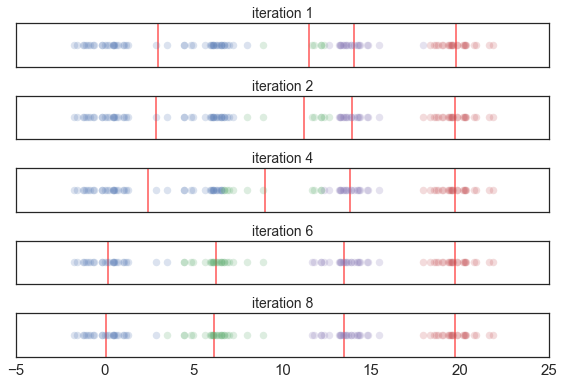

In [6]:
np.random.seed(12)
centroids, clusters = Kmeans_1D(data, k=4, plot_iter=5, verbose=True)

Data in each cluster are shown in different colors and the centroids are shown as red vertical lines. So, it seems like we got decent clustering, similar to what we would expect by eye. We can see that, although initially our centroids are not ideal, they move relatively quickly to better positions. 

## Effect of centroid initialization

Since we are initializing our centroids randomly, let's look at what happens when they start in a different state.



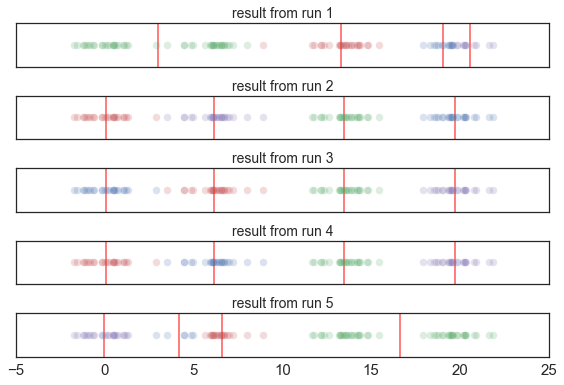

In [21]:
# cluster a bunch of times with different initial random states
centroids, clusters = [], []
runs = 5
for i in range(runs):
    np.random.seed(i+5)
    centroids_, clusters_ = Kmeans_1D(data, k=4)
    centroids.append(centroids_)
    clusters.append(clusters_)

# take a look
plot_clustering(clusters, centroids, runs, title='result from run')

It seems like not every time we can do a good job. That is because this algorithm converges to a $local$ optimum that largely depends on the initial centroids. It is then generally a good idea to run the algorithm multiple times, and take the best result that we get. We can quantify how good a given result is by measuring the inertia.

In [8]:
def inertia(clusters):
    """
    Compute within cluster sum of squares
    """
    return sum([np.sum((c - np.mean(c))**2) for c in clusters])

In [9]:
inertias = [inertia(c) for c in clusters]
for i, inrt in enumerate(inertias): print('result from run {0} has inertia of {1}'.format(i+1, inrt))

result from run 1 has inertia of 542.644351211634
result from run 2 has inertia of 102.48986727940299
result from run 3 has inertia of 102.489867279403
result from run 4 has inertia of 102.489867279403
result from run 5 has inertia of 559.27790840675


This is consistent with what we saw: the first and fourth are the worst results, while the other runs converged to a similiar result. In particular, we got bad results mainly because a pair of centroids were initialized too close to each other. So, in addition to running the algorithm multiple times, being smart about the initial position of the centroids, e.g. making them distant from each other, can be helpful. These tricks and more are incorporated in the [k-means implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) of the [sklearn.cluster](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module, which we will later use to cluster real data. 

## A note on $k$
Since we generated these data from four normal distributions, it seemed like a good idea to use $k=4$. But what if we didn't have that information? how many clusters should we expect? In other words, what $k$ should we use?

As we said before, there is no universally correct way of clustering. But there are a few methods that can give us some insight as to what $k$ to use. These involve measuring some metric as we change $k$, and we are already familiar with one such metric: the inertia. Let's try that.

In [10]:
def elbow(k_max, data, plot=False):
    """
    Get the inertia from clustering with different k for elbow method
    """    
    inertias, ks = [], []
    for k in range(2, k_max):
        # cluster
        centroids, clusters = Kmeans_1D(data, k)
        # compute inertia
        inertia_ = inertia(clusters)
        # save inertia and k
        inertias.append(inertia_)
        ks.append(k)
    if plot: 
        plt.plot(ks, inertias)
        plt.xlabel(r'$k$')
        plt.ylabel(r'inertia')
    return ks, inertias

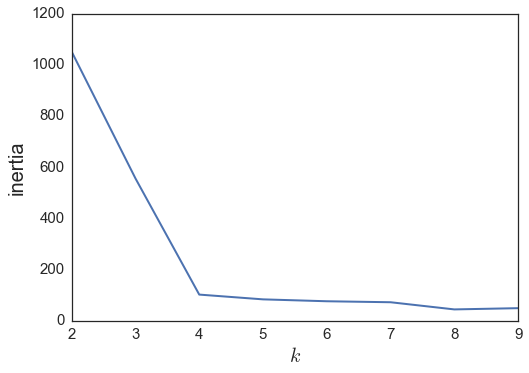

In [11]:
np.random.seed(12)
ks, inertias = elbow(10, data, plot=True);

The inertia initially drops very rapidly with $k$, and then keeps droping more slowly as $k$ increases. The trick here is to identify when the marginal gain drops, i.e. when increasing $k$ is no longer worth it. In this case, it is very evident that the sharp angle we get when $k=4$ is probably the point we want. This is called the *elbow method*, and worked nicely for this particular dataset, but it might not for others. In such cases, we might want to try [other ways of determining a reasonable number of clusters](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set).

We can also notice that the bigger $k$ is, the smaller the inertia. Why this happens becomes evident if we consider the case where $k = N$, where $N$ is the size of the data set. In that extreme case, every point is its own cluster, and the distance between each point and the center of its cluster (that same point) is zero, so there is no inertia.



## Who is buzzing?

Let's now look at a cool, real data set: insect wing beat sound. It was collected by [Yanping Chen](http://alumni.cs.ucr.edu/~ychen053/) and is available in the [UCR time series classification archive](http://www.cs.ucr.edu/~eamonn/time_series_data/). 

In a nutshell, these data were collected by recording the sounds of several flying insects. The insect sound was then extracted, cleaned and transformed to a frequency spectrum using the [discrete fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform). [Here](https://sites.google.com/site/insectclassification/) is a more complete description if you are interested.

Let's import the data and take a look.

There are 220 recordings, this is a 220 by 257 array.


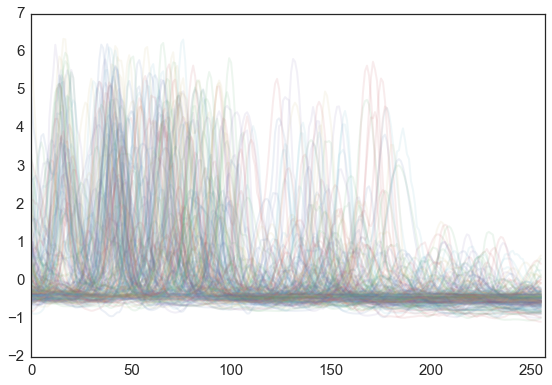

In [26]:
insect_data = np.genfromtxt('./data/UCR_TS_Archive_2015/InsectWingbeatSound/InsectWingbeatSound_TRAIN', delimiter=',')
plt.plot(insect_data[:,1:].transpose(), alpha=0.1);
plt.tight_layout()
plt.xlim(0, insect_data.shape[1]);
print('There are {0} recordings, this is a {0} by {1} array.'.format(insect_data.shape[0],insect_data.shape[1]))

Sounds like many insects...can we figure out how many different *kinds* of insects were recorded? 

Let's try clustering! 

If we can figure out how many clusters there are in these data (assuming we do a decent job  clustering it), we could get an idea of how many different kinds of insects there are. So let's start by using the elbow method to try to choose a reasonable $k$. We can re-write our function to use the better K-means implementation from the sklearn.cluster module.

In [27]:
def elbow(k_max, data, plot=False):
    """
    Get the inertia from clustering with different k for elbow method
    """    
    inertias, ks = [], []
    for k in range(2, k_max):
        # initialize K-means, cluster and get inertia
        inertia_ = KMeans(n_clusters=k, random_state=12).fit(data).inertia_
        # save inertia and k
        inertias.append(inertia_)
        ks.append(k)
    if plot: 
        plt.plot(ks, inertias)
        plt.plot(ks, inertias, '.')
        plt.xlabel(r'$k$')
        plt.ylabel(r'inertia')
    return ks, inertias

We can now look at how the inertia changes with $k$.

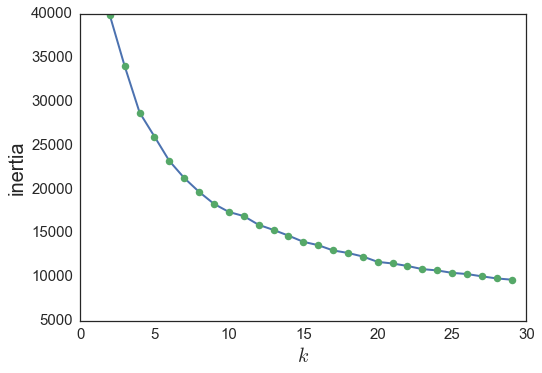

In [24]:
ks, inertias = elbow(30, insect_data[:,1:], plot=True)

Here the number of clusters is not so obvious. Somewhere around 10 looks like a reasonable choice, but we can try another metric to get a better idea. 

We will use the [silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), which is another measure of how tight are data within clusters and how far they are from the neighboring clusters. It ranges from [-1, 1], with increasing value suggesting better clustering. 

We can write a similar function to get the silhouette score for different $k$s. We will use the silhouette score function available in [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [25]:
def silhouette(k_max, data, plot=False):
    """
    Get the silhouette score from clustering with different k
    """    
    sil, ks = [], []
    for k in range(2, k_max):
        # initialize K-means, cluster and get labels
        labels = KMeans(n_clusters=k, random_state=12).fit_predict(data)
        # compute silhouette score
        sil_ = silhouette_score(data, labels)
        sil.append(sil_)
        ks.append(k)
    if plot: 
        plt.plot(ks, sil)
        plt.plot(ks, sil, '.')
        plt.xlabel(r'$k$')
        plt.ylabel(r'silhouette score')
    return ks, sil

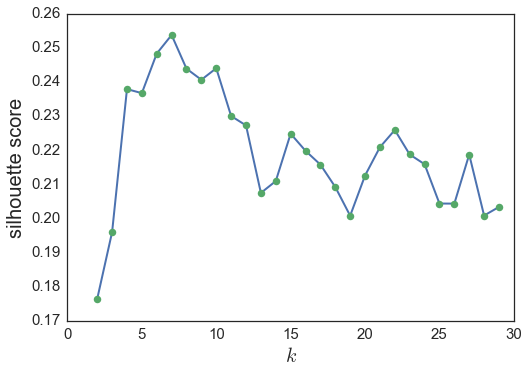

In [16]:
ks, sil = silhouette(30, insect_data[:,1:], plot=True)

This also suggests that 10, but also 7, are reasonable choices. So we'll go with the consensus and guess there are about 10 different insect kinds in the data set.

Actually, these data are labeled, so we can find out exactly how many different insects exist. The first column of the dataset contains the labels.

In [17]:
print('There are {0} different kinds of flying insects.'.format(np.unique(insect_data[:,0]).shape[0]))

There are 11 different kinds of flying insects.


Our guess was not too bad. It seems like we can get an intuition of the structure of the data through this exploratory cluster analysis, which can be easy to perform with all the functions that we have available in the sklearn module. 

Let's cluster the data and look at how a couple of insect kinds might sound like.

In [18]:
# we first instantiate the KMeans class
kmeans_insect = KMeans(n_clusters=11, random_state=12)
# Now we can cluster our data and access the results through the class attributes
kmeans_insect.fit(insect_data[:,1:])
# the labels are one such attribute. Others are inertia and cluster centers.
labels = kmeans_insect.labels_

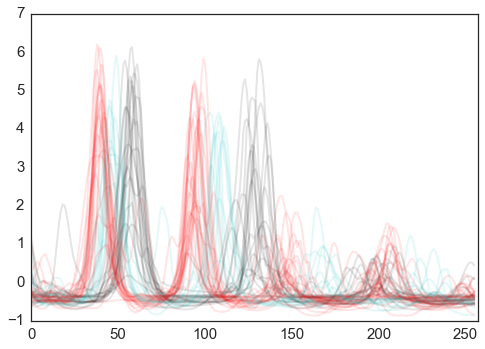

In [28]:
colors = ['k','r','c','y','g']
np.random.seed(9)
for i,l in enumerate(np.random.choice(np.unique(labels), size=3, replace=False)):
    plt.plot(insect_data[:,1:][np.where(labels==l)].transpose(), c=colors[i], alpha=0.1);
    plt.xlim(0, insect_data.shape[1])

The clusters seem to make sense; each kind of insect does seem to sound somewhat different. Since we know the labels of the data, we can compare it to the results of our clustering. This information would normally not be available, but comparing clustering results can be useful, e.g. to compare different algorithms.

Sklearn also has a few evaluation metrics for clustering analysis. Because we have the ground thruth, i.e. the labels, we are interested in a supervised evaluation. We will try two metrics: adjusted random and completeness scores (there are more, this are just easy to explain). For random score, the similarity goes between [-1,1], with a value close to zero for random labeling and 1 for perfect labeling, and gives us an idea of how we are doing compared to random. This score is adjusted for matching labels that we might expect by chance only. The completeness score ranges between [0,1], and tells us about what proportion of points that have the same label were clustered together, with a score of 1 being a perfect match.

In [30]:
labels_true = insect_data[:,0]
labels_pred = labels
rand_score = metrics.adjusted_rand_score(labels_true, labels_pred)
comp_score = metrics.completeness_score(labels_true, labels_pred)
print('random score = {0}\ncompleteness score = {1}'.format(rand_score, comp_score))

random score = 0.3060668991166375
completeness score = 0.5467206029163796


Looks like we are doing better than random, but we are not able to correctly classify all the insects. We might want to try another clustering method. Particularly, a different metric, such as [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping), may be useful for these kind of data. 